In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import time
import sklearn
import torch
from scipy.sparse import csr_matrix

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
print(torch.version.cuda) 

12.0


In [3]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

        # Additional information (compute capability, memory)
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {gpu_props.major}.{gpu_props.minor}")
        print(f"  Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe MIG 3g.40gb
  Compute Capability: 8.0
  Total Memory: 39.25 GB


In [4]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [5]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.70 GB, difference +8.70 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [6]:
df[df['standard_cell_type'] == 'HSC'].tail()

,obs_index,cell_type,standard_cell_type
cell_id,,,
TSP2_BM_vertebralbody_SS2_B113699_B133090_LinNegMarrow_D15_S87_tabula_sapiens,TSP2_BM_vertebralbody_SS2_B113699_B133090_LinN...,HSC,HSC
TSP2_BM_vertebralbody_SS2_B113699_B133090_LinNegMarrow_E14_S110_tabula_sapiens,TSP2_BM_vertebralbody_SS2_B113699_B133090_LinN...,HSC,HSC
TSP2_BM_vertebralbody_SS2_B113699_B133090_LinNegMarrow_E23_S119_tabula_sapiens,TSP2_BM_vertebralbody_SS2_B113699_B133090_LinN...,HSC,HSC
TSP2_BM_vertebralbody_SS2_B113699_B133090_LinNegMarrow_G22_S166_tabula_sapiens,TSP2_BM_vertebralbody_SS2_B113699_B133090_LinN...,HSC,HSC
TSP2_BM_vertebralbody_SS2_B113699_B133090_LinNegMarrow_H17_S185_tabula_sapiens,TSP2_BM_vertebralbody_SS2_B113699_B133090_LinN...,HSC,HSC


In [7]:
fpaths = [
    "../resources/PanglaoDB_Augmented_2021.txt",
    "../resources/Tabula_Sapiens.txt",
]

marker_columns = []

for fpath in fpaths:    
    features = ut.load_pathway(fpath)

    # extract columns
    hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
    fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
    fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
    columns = list(set(hsc_columns + fib_columns))

    for col in columns:
        gene_list = list(features[features[col].astype(bool)].index)
        print(col, len(gene_list))
        col_name = col.lower().replace("-", " ")
        col_name = col_name.replace(" ", "_") + "_marker"
        marker_columns.append(col_name)
        adata.var[col_name] = adata.var.index.isin(gene_list)
    
adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
print()
adata

Fibroblasts 232
Hematopoietic Stem Cells 178
Large Intestine-fibroblast 100
Vasculature-fibroblast 100
Lung-alveolar Fibroblast 100
Lymph Node-hematopoietic Stem Cell 100
Prostate-fibroblast 100
Uterus-fibroblast 100
Liver-fibroblast 100
Lung-fibroblast 100
Tongue-fibroblast 100
Bladder-fibroblast 100
Pancreas-fibroblast 100
Spleen-hematopoietic Stem Cell 100
Heart-fibroblast Of Cardiac Tissue 100
Fat-fibroblast 100
Small Intestine-fibroblast 100
Trachea-fibroblast 100
Eye-fibroblast 100
Blood-hematopoietic Stem Cell 100
Mammary-fibroblast Of Breast 100
Bone Marrow-hematopoietic Stem Cell 100
Salivary Gland-fibroblast 100
Thymus-fibroblast 100



AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'large_intestine_fibroblast_marker', 'vasculature_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'uterus_fibroblast_marker', 'liver_fibroblast_marker', 'lung_fibroblast_marker', 'tongue_fibroblast_marker', 'bladder_fibroblast_marker', 'pancreas_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'mammary_fibroblast_of_breast_m

In [8]:
list(adata.obs['standard_cell_type'].unique())

['PreBNK',
 'LinNeg',
 'HSC',
 'CMP',
 'MEP',
 'MPP',
 'GMP',
 'MLP',
 'EryP',
 'MDP',
 'MKP',
 'Mono',
 'CLP',
 'T_cell',
 'B_cell',
 'NK',
 nan,
 'LMPP',
 'Dendritic_cell',
 'Fib',
 'iHSC']

# Filtering

In [9]:
# def filter_genes_by_group_min_count(adata, group_key, min_count):
#     """Filters genes in an AnnData object based on minimum count within all groups.

#     Args:
#         adata: The AnnData object.
#         group_key: The key in `adata.obs` that defines the groups.
#         min_count: The minimum count required for a gene within each group.

#     Returns:
#         AnnData: A new AnnData object with the filtered genes.
#     """

#     gene_mask = None
#     for group_name in adata.obs[group_key].unique():
#         group_adata = adata[adata.obs[group_key] == group_name, :]
#         gene_counts = group_adata.X.sum(axis=0)
#         group_mask = gene_counts >= min_count
#         print(f"{group_key}: {group_name} - {group_mask.sum()} genes pass filter")

#         if gene_mask is None:
#             gene_mask = group_mask
#         else:
#             gene_mask = gene_mask & group_mask

#     filtered_adata = adata[:, gene_mask].copy()
#     return filtered_adata
    
# adata = filter_genes_by_group_min_count(
#     adata, 
#     group_key='dataset',
#     min_count=1,
# )

# adata

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

adata

AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'large_intestine_fibroblast_marker', 'vasculature_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'uterus_fibroblast_marker', 'liver_fibroblast_marker', 'lung_fibroblast_marker', 'tongue_fibroblast_marker', 'bladder_fibroblast_marker', 'pancreas_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'mammary_fibroblast_of_breast_m

In [11]:
cell_types = [
    'PreBNK',
    'LinNeg',
    'HSC',
    'CMP',
    'MEP',
    'MPP',
    'GMP',
    'MLP',
    'EryP',
    'MDP',
    'MKP',
    'Mono',
    'CLP',
    'T_cell',
    'B_cell',
    'NK',
    'LMPP',
    'Dendritic_cell',
    'Fib',
    'iHSC',
]

adata = adata[adata.obs['standard_cell_type'].notna(), :].copy()
adata = adata[adata.obs['standard_cell_type'].isin(cell_types), :].copy()

sorted(adata.obs['standard_cell_type'].unique())

['B_cell',
 'CLP',
 'CMP',
 'Dendritic_cell',
 'EryP',
 'Fib',
 'GMP',
 'HSC',
 'LMPP',
 'LinNeg',
 'MDP',
 'MEP',
 'MKP',
 'MLP',
 'MPP',
 'Mono',
 'NK',
 'PreBNK',
 'T_cell',
 'iHSC']

# Randomly subsample the tabula sapiens fibroblast data

In [12]:
sample_size = 1e4 # the numbner of fibroblast signatures to keep

mask = (adata.obs['dataset'] == 'tabula_sapiens') & (adata.obs['standard_cell_type'] == 'Fib')

print(f"Filtering for Fibroblasts from tabula_sapiens dataset...")
fibdf = adata.obs[mask].copy()
print(f"Found {len(fibdf)} fibroblasts.")

print(f"Sampling {sample_size} fibroblasts...")
keep = fibdf.sample(int(sample_size))
keep = keep.index
print("Sampling complete.")

fib_to_drop = fibdf[~fibdf.index.isin(keep)].index
all_keep = ~adata.obs.index.isin(fib_to_drop)

# Print the lengths
print(f"Total fibroblasts: {len(adata.obs.index)}")
print(f"Fibroblasts to keep: {len(keep)}")
print(f"Fibroblasts to drop: {len(fib_to_drop)}") 

adata = adata[all_keep, :].copy()  
adata

Filtering for Fibroblasts from tabula_sapiens dataset...
Found 26553 fibroblasts.
Sampling 10000.0 fibroblasts...
Sampling complete.
Total fibroblasts: 168264
Fibroblasts to keep: 10000
Fibroblasts to drop: 16553


AnnData object with n_obs × n_vars = 151711 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'large_intestine_fibroblast_marker', 'vasculature_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'uterus_fibroblast_marker', 'liver_fibroblast_marker', 'lung_fibroblast_marker', 'tongue_fibroblast_marker', 'bladder_fibroblast_marker', 'pancreas_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'mammary_fibroblast_of_breast_m

# Preprocessing

In [13]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

normalizing counts per cell
    finished (0:00:01)


AnnData object with n_obs × n_vars = 151711 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'large_intestine_fibroblast_marker', 'vasculature_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'uterus_fibroblast_marker', 'liver_fibroblast_marker', 'lung_fibroblast_marker', 'tongue_fibroblast_marker', 'bladder_fibroblast_marker', 'pancreas_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'mammary_fibroblast_of_breast_m

# Make reference and query data

In [14]:
reference_data = [
    'tabula_sapiens',
    'weng_young2_all',
    'sc_fib',
    'pellin',
    # 'weng_young2_HSC',
    # 'weng_young1_all_t2',
    # 'weng_young1_all_t1',
]

query_data = [
    'iHSC',
]

# define data sets
rdata = adata[adata.obs['dataset'].isin(reference_data), :].copy()
print(rdata)
qdata = adata[adata.obs['dataset'].isin(query_data), :].copy()
print(qdata)

AnnData object with n_obs × n_vars = 66500 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'fibroblasts_marker', 'hematopoietic_stem_cells_marker', 'large_intestine_fibroblast_marker', 'vasculature_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'uterus_fibroblast_marker', 'liver_fibroblast_marker', 'lung_fibroblast_marker', 'tongue_fibroblast_marker', 'bladder_fibroblast_marker', 'pancreas_fibroblast_marker', 'spleen_hematopoietic_stem_cell_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'fat_fibroblast_marker', 'small_intestine_fibroblast_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'mammary_fibroblast_of_breast_ma

In [15]:
rdata.obs['cell_label'] = rdata.obs['standard_cell_type'].apply(lambda x: str(x).strip())
rdata.obs['cell_label'].value_counts()

cell_label
Fib               17736
LinNeg            13396
HSC                6978
MEP                4817
T_cell             4507
B_cell             2915
MPP                2515
EryP               2127
GMP                1934
MKP                1932
CMP                1889
Mono               1434
MDP                1138
NK                 1017
CLP                 947
PreBNK              554
LMPP                459
MLP                 123
Dendritic_cell       82
Name: count, dtype: int64

In [16]:
qdata.obs['cell_label'] = 'Unknown'
qdata.obs['cell_label'].value_counts()

cell_label
Unknown    8379
Name: count, dtype: int64

# Reference Mapping (scANVI)

In [17]:
sc.pp.highly_variable_genes(
    rdata, 
    n_top_genes=1000,
    batch_key="dataset", 
    subset=True,
    layer='log_norm',
)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
scvi.model.SCVI.setup_anndata(
    rdata, 
    batch_key="dataset",
    layer="counts",
    labels_key='cell_label',
)

In [19]:
torch.cuda.empty_cache()

model = scvi.model.SCVI(
    rdata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=4,
)

start_time = time.time()  # Record the start time

model.train(
    max_epochs=25,
    accelerator='gpu',
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs={"weight_decay": 0.1},
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


Training completed in 91.09 seconds
Training time: 1 minutes 31 seconds


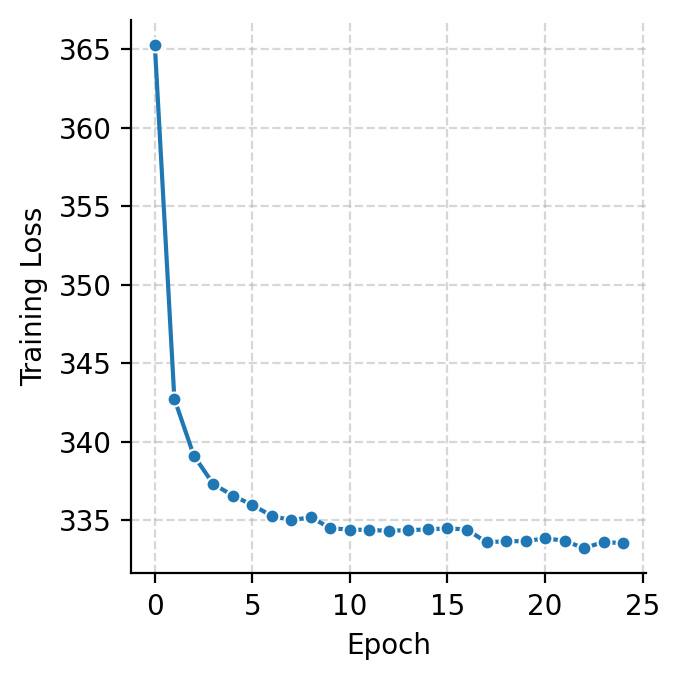

In [20]:
metrics = pd.concat(
    model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# SCANVI Model

In [21]:
torch.cuda.empty_cache()

# train the scanvi model
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model, 
    unlabeled_category="Unknown",
)

scanvi_model.train(
    max_epochs=25,
    accelerator='gpu',
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs={"weight_decay": 0.1},
)

INFO     Training for 25 epochs.                                                                                   


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-cfb2a8ae-864b-50df-94a5-98983023f29d]
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/pytorch/trainer/

Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


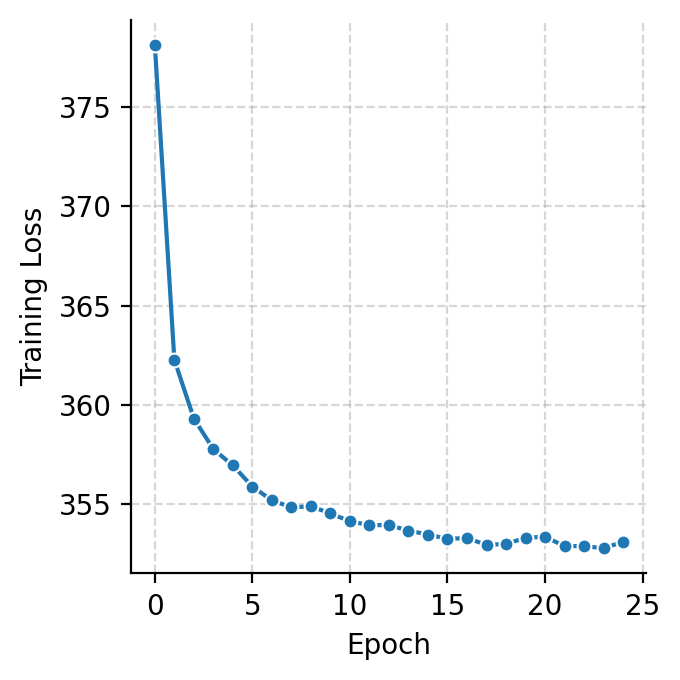

In [22]:
metrics = pd.concat(
    scanvi_model.history.values(), 
    ignore_index=False,
    axis=1
)
metrics = metrics.reset_index()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=metrics,
    x='epoch',
    y='train_loss_epoch',
    linewidth=1.5,               
    marker='o',          
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks()
plt.yticks()
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Latent Representations (SCVI)

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
SCANVI_LATENT_KEY = "X_scANVI"

rdata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
rdata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

sc.pp.neighbors(
    rdata, 
    n_neighbors=45,
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.leiden(
    rdata, 
    key_added='scanvi_clusters',
)
sc.tl.umap(
    rdata,
)
sc.pl.umap(
    rdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'scanvi_clusters',
    ],
    ncols=1,
)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
running Leiden clustering


/tmp/ipykernel_2652757/2167781162.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 40 clusters and added
    'scanvi_clusters', the cluster labels (adata.obs, categorical) (0:00:16)
computing UMAP


In [ ]:
break

# Query mapping (SCANVI)

In [ ]:
scvi.model.SCANVI.prepare_query_anndata(
    qdata, 
    scanvi_model,
)

scanvi_query = scvi.model.SCANVI.load_query_data(
    qdata, 
    scanvi_model,
)

# ## IF USING SCVI
# scvi.model.SCVI.prepare_query_anndata(
#     qdata, 
#     model,
# )

# scvi_query = scvi.model.SCVI.load_query_data(
#     qdata,
#     model,
# )

print('Done!')

In [ ]:
torch.cuda.empty_cache()

SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

scanvi_query.train(
    max_epochs=5, 
    plan_kwargs={"weight_decay": 0.0},
)

qdata.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
qdata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

qdata

In [ ]:
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

qdata.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
qdata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()
qdata.obs[SCANVI_PREDICTIONS_KEY].value_counts()

# Predicted Probability

In [ ]:
pred_proba = scanvi_query.predict(soft=True)
pred_proba.head()

In [ ]:
sns.histplot(
    data=pred_proba,
    x='HSC',
    log_scale=True,
    bins=31,
)

# Integrate

In [ ]:
fdata = an.concat([rdata, qdata], label="batch")
fdata

In [ ]:
sc.pp.neighbors(
    fdata, 
    use_rep=SCANVI_LATENT_KEY,
)

sc.tl.umap(
    fdata,
    min_dist=0.15,
)
sc.pl.umap(
    fdata, 
    color=[
        'dataset',
        'standard_cell_type',
        'batch',
    ],
    ncols=1,
)

In [ ]:
cell_types = [
    'iHSC',
    'Fib',
    'HSC',
]

datasets = [
    'sc_fib',
    'iHSC',
    'weng_young2_all',
]

mask = fdata.obs['dataset'].isin(datasets) & fdata.obs['standard_cell_type'].isin(cell_types)

sc.pl.umap(
    fdata[mask, :],
    color=[
        'standard_cell_type',
    ],
    ncols=1,
)

# Filtering

In [ ]:
# cell_types = [
#     'iHSC',
#     'Fib',
#     'HSC',
# ]

# datasets = [
#     'sc_fib',
#     'iHSC',
#     'weng_young2_all',
# ]

# bdata = fdata[fdata.obs['standard_cell_type'].isin(cell_types), :].copy()
# bdata = bdata[bdata.obs['dataset'].isin(datasets), :].copy()
# bdata